# Feature Engineering - GUIDE Dataset

**Obiettivo:** Preparare il dataset GUIDE per il machine learning, creando features significative a livello Incident.

**Task:** Classificazione multi-classe di IncidentGrade (TruePositive, BenignPositive, FalsePositive)

**Approccio:**
1. Aggregare dati da Evidence → Alert → Incident level
2. Creare features numeriche e categoriche
3. Gestire valori mancanti
4. Codificare variabili categoriche
5. Salvare dataset processato per modeling

## 1. Setup e Caricamento Dati

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Librerie importate con successo!")

Librerie importate con successo!


In [5]:
# Carica il dataset pulito dall'EDA
file_path = '../data/GUIDE_Train.csv'

print("Caricamento dataset...")
df = pd.read_csv(file_path)

print(f"Dataset caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Caricamento dataset...
Dataset caricato: 9,516,837 righe, 45 colonne
Memoria: 7890.70 MB


## 2. Pulizia Iniziale

In [6]:
# Rimuovi record senza target
print(f"Record con IncidentGrade nullo: {df['IncidentGrade'].isna().sum()}")
df = df[df['IncidentGrade'].notna()].copy()

# Rimuovi colonne con >97% missing
missing_pct = (df.isnull().sum() / len(df)) * 100
cols_to_drop = missing_pct[missing_pct > 97].index.tolist()
print(f"\nColonne rimosse (>97% missing): {cols_to_drop}")
df = df.drop(columns=cols_to_drop)

# Rimuovi duplicati su Id
duplicati = df['Id'].duplicated().sum()
print(f"\nDuplicati su Id: {duplicati}")
if duplicati > 0:
    df = df.drop_duplicates(subset=['Id'], keep='first')

print(f"\nDimensioni dopo pulizia: {df.shape}")

Record con IncidentGrade nullo: 51340

Colonne rimosse (>97% missing): ['ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection']

Duplicati su Id: 8758389

Dimensioni dopo pulizia: (707108, 38)


## 3. Parsing Temporale

In [7]:
# Converti Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['TimeOfDay'] = pd.cut(df['Hour'], bins=[0, 6, 12, 18, 24], 
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                         include_lowest=True)

print("Features temporali create")
print(f"Range temporale: {df['Timestamp'].min()} - {df['Timestamp'].max()}")

Features temporali create
Range temporale: 2023-11-20 16:32:22+00:00 - 2024-06-17 14:45:38+00:00


## 4. Aggregazione a Livello Incident

Questo è il passo più importante: trasformiamo le evidenze in features a livello incident.

In [8]:
print("Creazione features aggregate per incident...\n")

# Funzione per ottenere il valore più comune (moda)
def get_mode(x):
    mode = x.mode()
    return mode[0] if len(mode) > 0 else x.iloc[0] if len(x) > 0 else None

# Aggregazioni per IncidentId
incident_agg = df.groupby('IncidentId').agg({
    # Target (sempre uguale per lo stesso incident)
    'IncidentGrade': 'first',
    
    # Conteggi strutturali
    'AlertId': 'nunique',           # Numero di alert nell'incident
    'Id': 'count',                   # Numero totale di evidenze
    'EntityType': 'nunique',         # Diversità di entity types
    'EvidenceRole': 'nunique',       # Diversità di evidence roles
    
    # Features categoriche (moda)
    'Category': get_mode,
    'DetectorId': get_mode,
    'OrgId': 'first',
    
    # Features temporali
    'Hour': ['min', 'max', 'mean'],
    'DayOfWeek': get_mode,
    'IsWeekend': 'max',
    'Timestamp': ['min', 'max'],     # Per calcolare durata
    
    # Features geografiche
    'CountryCode': 'nunique',
    'State': 'nunique',
    'City': 'nunique',
    
    # Features tecniche
    'DeviceId': 'nunique',
    'OSFamily': 'nunique',
    'OSVersion': 'nunique',
    
    # Features di sicurezza
    'SuspicionLevel': lambda x: x.notna().sum(),  # Quante evidenze hanno suspicion
    'LastVerdict': lambda x: x.notna().sum(),     # Quante hanno verdict
}).reset_index()

# Rinomina colonne multi-livello
incident_agg.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                        for col in incident_agg.columns.values]

print(f"Dataset aggregato creato: {incident_agg.shape}")
print(f"\nPrime colonne: {list(incident_agg.columns[:10])}")

Creazione features aggregate per incident...

Dataset aggregato creato: (448901, 24)

Prime colonne: ['IncidentId', 'IncidentGrade_first', 'AlertId_nunique', 'Id_count', 'EntityType_nunique', 'EvidenceRole_nunique', 'Category_get_mode', 'DetectorId_get_mode', 'OrgId_first', 'Hour_min']


In [9]:
# Calcola durata incident (differenza tra prima e ultima evidenza)
incident_agg['Duration_seconds'] = (
    pd.to_datetime(incident_agg['Timestamp_max']) - 
    pd.to_datetime(incident_agg['Timestamp_min'])
).dt.total_seconds()

# Rinomina colonne per chiarezza
rename_map = {
    'AlertId_nunique': 'NumAlerts',
    'Id_count': 'NumEvidences',
    'EntityType_nunique': 'NumEntityTypes',
    'EvidenceRole_nunique': 'NumEvidenceRoles',
    'Hour_min': 'Hour_First',
    'Hour_max': 'Hour_Last',
    'Hour_mean': 'Hour_Avg',
    'CountryCode_nunique': 'NumCountries',
    'State_nunique': 'NumStates',
    'City_nunique': 'NumCities',
    'DeviceId_nunique': 'NumDevices',
    'OSFamily_nunique': 'NumOSFamilies',
    'OSVersion_nunique': 'NumOSVersions',
    'SuspicionLevel_<lambda>': 'NumWithSuspicion',
    'LastVerdict_<lambda>': 'NumWithVerdict',
}

incident_agg = incident_agg.rename(columns=rename_map)

# Rimuovi colonne timestamp originali
incident_agg = incident_agg.drop(columns=['Timestamp_min', 'Timestamp_max'], errors='ignore')

print(f"Features ingegnerizzate: {incident_agg.shape[1] - 2}")  # -2 per IncidentId e target
incident_agg.head()

Features ingegnerizzate: 21


,IncidentId,IncidentGrade_first,NumAlerts,NumEvidences,NumEntityTypes,NumEvidenceRoles,Category_get_mode,DetectorId_get_mode,OrgId_first,Hour_First,...,IsWeekend_max,NumCountries,NumStates,NumCities,NumDevices,NumOSFamilies,NumOSVersions,NumWithSuspicion,NumWithVerdict,Duration_seconds
0,0,TruePositive,1,1,1,1,InitialAccess,0,50,8,...,0,1,1,1,1,1,1,0,0,0.0
1,2,BenignPositive,2,2,2,2,Execution,1,42,8,...,0,1,1,1,1,1,1,1,1,74244.0
2,3,TruePositive,1,1,1,1,SuspiciousActivity,5,457,16,...,1,1,1,1,1,1,1,0,0,0.0
3,7,BenignPositive,11,11,7,2,InitialAccess,0,14,5,...,1,3,4,4,2,2,2,2,4,1888021.0
4,8,TruePositive,2,2,2,1,InitialAccess,96,382,20,...,0,1,1,1,1,1,1,0,0,180032.0


## 5. Feature Engineering Avanzato - MITRE Techniques

In [10]:
# Analizza MITRE Techniques
print("Processing MITRE Techniques...")

# Crea features da MitreTechniques
mitre_features = df.groupby('IncidentId')['MitreTechniques'].agg([
    ('NumWithMitre', lambda x: x.notna().sum()),  # Quante evidenze hanno tecniche MITRE
    ('NumUniqueMitre', lambda x: len(set(','.join(x.dropna().astype(str)).split(',')))),  # Tecniche uniche
]).reset_index()

# Merge con dataset principale
incident_agg = incident_agg.merge(mitre_features, on='IncidentId', how='left')

print(f"Features MITRE aggiunte. Shape: {incident_agg.shape}")

Processing MITRE Techniques...
Features MITRE aggiunte. Shape: (448901, 25)


## 6. Gestione Valori Categorici

In [11]:
# Identifica colonne categoriche
categorical_cols = incident_agg.select_dtypes(include=['object', 'category']).columns.tolist()

# Rimuovi IncidentId e IncidentGrade
categorical_cols = [col for col in categorical_cols if col not in ['IncidentId', 'IncidentGrade']]

print(f"Colonne categoriche da processare: {categorical_cols}")

# Per colonne con alta cardinalità, sostituisci valori rari con 'Other'
for col in categorical_cols:
    if incident_agg[col].nunique() > 100:
        # Mantieni solo i top 50 valori
        top_values = incident_agg[col].value_counts().head(50).index
        incident_agg[col] = incident_agg[col].apply(lambda x: x if x in top_values else 'Other')
        print(f"  {col}: ridotto a {incident_agg[col].nunique()} categorie")

Colonne categoriche da processare: ['IncidentGrade_first', 'Category_get_mode']


## 7. Preparazione per ML: Train/Test Split

In [12]:
# Separa features e target
X = incident_agg.drop(columns=['IncidentId', 'IncidentGrade_first'])
y = incident_agg['IncidentGrade_first']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nDistribuzione target:")
print(y.value_counts())
print(f"\nProporzioni:")
print(y.value_counts(normalize=True))

Features shape: (448901, 23)
Target shape: (448901,)

Distribuzione target:
IncidentGrade_first
BenignPositive    218131
FalsePositive     135158
TruePositive       95612
Name: count, dtype: int64

Proporzioni:
IncidentGrade_first
BenignPositive    0.485922
FalsePositive     0.301086
TruePositive      0.212991
Name: proportion, dtype: float64


In [14]:
# Label encoding per variabili categoriche
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le

print(f"Encoded {len(label_encoders)} categorical features")
print(f"\nTipi di dati finali:")
print(X_encoded.dtypes.value_counts())

Encoded 1 categorical features

Tipi di dati finali:
int64      18
int32       3
float64     2
Name: count, dtype: int64


In [15]:
# Gestisci missing values
print("\nMissing values prima dell'imputazione:")
missing = X_encoded.isnull().sum()
print(missing[missing > 0])

# Sostituisci NaN con -999 (XGBoost gestisce bene questo approccio)
X_encoded = X_encoded.fillna(-999)

print(f"\nMissing values dopo imputazione: {X_encoded.isnull().sum().sum()}")


Missing values prima dell'imputazione:
Series([], dtype: int64)

Missing values dopo imputazione: 0


In [16]:
# Split stratificato
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print("Train/Test Split completato")
print(f"\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribuzione y_test:")
print(y_test.value_counts(normalize=True))

Train/Test Split completato

X_train: (359120, 23)
X_test: (89781, 23)

Distribuzione y_train:
IncidentGrade_first
BenignPositive    0.485921
FalsePositive     0.301086
TruePositive      0.212993
Name: proportion, dtype: float64

Distribuzione y_test:
IncidentGrade_first
BenignPositive    0.485927
FalsePositive     0.301088
TruePositive      0.212985
Name: proportion, dtype: float64


## 8. Salvataggio Dataset Processato

In [17]:
# Salva i dataset processati
import pickle

# Crea directory per i dati processati
import os
os.makedirs('../data/processed', exist_ok=True)

# Salva train/test
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=['IncidentGrade'])
y_test.to_csv('../data/processed/y_test.csv', index=False, header=['IncidentGrade'])

# Salva label encoders
with open('../data/processed/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Salva anche il dataset aggregato completo
incident_agg.to_csv('../data/processed/incident_features.csv', index=False)

print("Dataset salvati in ../data/processed/")
print(f"  - X_train.csv: {X_train.shape}")
print(f"  - X_test.csv: {X_test.shape}")
print(f"  - y_train.csv: {y_train.shape}")
print(f"  - y_test.csv: {y_test.shape}")
print(f"  - incident_features.csv: {incident_agg.shape}")

Dataset salvati in ../data/processed/
  - X_train.csv: (359120, 23)
  - X_test.csv: (89781, 23)
  - y_train.csv: (359120,)
  - y_test.csv: (89781,)
  - incident_features.csv: (448901, 25)


## 9. Analisi Features Create

In [19]:
# Lista features create
print(f"Totale features: {X_encoded.shape[1]}")
print(f"\nLista completa features:")
for i, col in enumerate(X_encoded.columns, 1):
    print(f"{i:2d}. {col}")

Totale features: 23

Lista completa features:
 1. NumAlerts
 2. NumEvidences
 3. NumEntityTypes
 4. NumEvidenceRoles
 5. Category_get_mode
 6. DetectorId_get_mode
 7. OrgId_first
 8. Hour_First
 9. Hour_Last
10. Hour_Avg
11. DayOfWeek_get_mode
12. IsWeekend_max
13. NumCountries
14. NumStates
15. NumCities
16. NumDevices
17. NumOSFamilies
18. NumOSVersions
19. NumWithSuspicion
20. NumWithVerdict
21. Duration_seconds
22. NumWithMitre
23. NumUniqueMitre


In [20]:
# Statistiche descrittive delle features numeriche principali
key_features = ['NumAlerts', 'NumEvidences', 'NumEntityTypes', 'NumDevices', 
                'Duration_seconds', 'NumWithMitre', 'NumCountries']

available_features = [f for f in key_features if f in X_encoded.columns]
X_encoded[available_features].describe()

,NumAlerts,NumEvidences,NumEntityTypes,NumDevices,Duration_seconds,NumWithMitre,NumCountries
count,448901.000000,448901.000000,448901.000000,448901.000000,4.489010e+05,448901.000000,448901.000000
mean,1.575198,1.575198,1.452209,1.043165,1.772810e+05,0.547123,1.043549
std,1.174543,1.174543,0.909125,0.213337,4.341154e+05,0.836719,0.214841
min,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000
75%,2.000000,2.000000,2.000000,1.000000,1.500040e+05,1.000000,1.000000
max,13.000000,13.000000,10.000000,4.000000,1.739726e+07,9.000000,5.000000


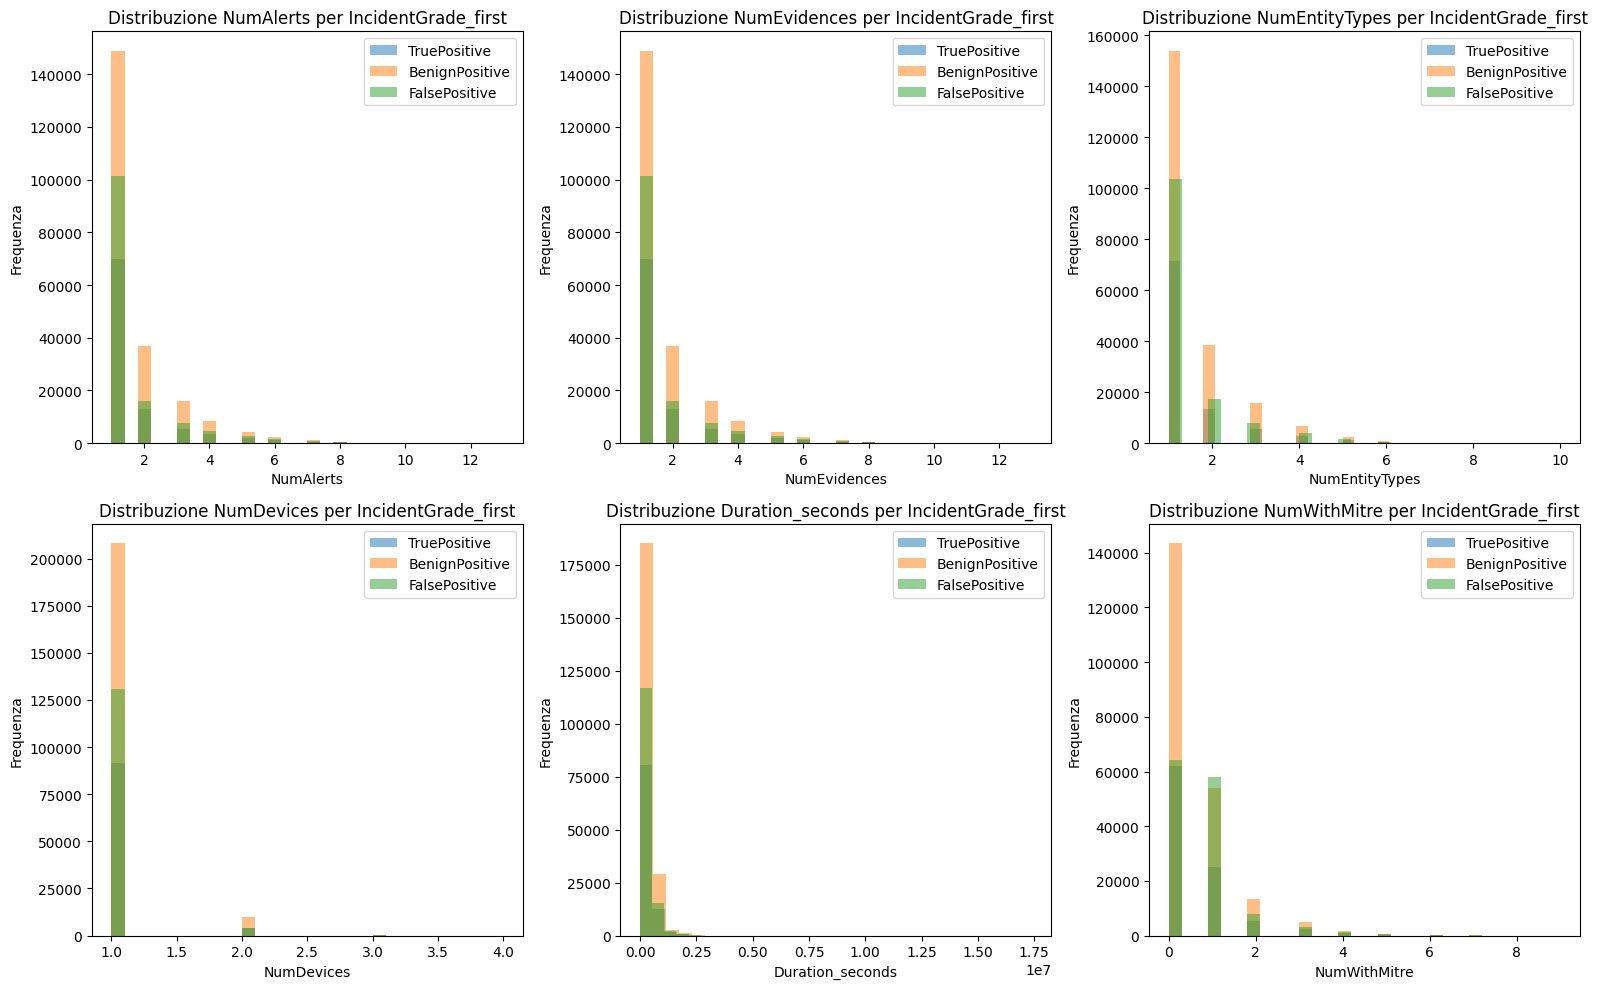

In [22]:
# Visualizza distribuzione di alcune features chiave per target
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

plot_features = ['NumAlerts', 'NumEvidences', 'NumEntityTypes', 
                 'NumDevices', 'Duration_seconds', 'NumWithMitre']

for i, feature in enumerate(plot_features):
    if feature in incident_agg.columns:
        for grade in incident_agg['IncidentGrade_first'].unique():
            data = incident_agg[incident_agg['IncidentGrade_first'] == grade][feature]
            axes[i].hist(data, alpha=0.5, label=grade, bins=30)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequenza')
        axes[i].legend()
        axes[i].set_title(f'Distribuzione {feature} per IncidentGrade_first')

plt.tight_layout()
plt.show()

## 10. Riepilogo Feature Engineering

**Features create:**
1. **Conteggi strutturali:** NumAlerts, NumEvidences, NumEntityTypes, NumEvidenceRoles
2. **Features temporali:** Hour_First, Hour_Last, Hour_Avg, DayOfWeek, IsWeekend, Duration_seconds
3. **Features geografiche:** NumCountries, NumStates, NumCities
4. **Features tecniche:** NumDevices, NumOSFamilies, NumOSVersions
5. **Features di sicurezza:** NumWithSuspicion, NumWithVerdict, NumWithMitre, NumUniqueMitre
6. **Features categoriche:** Category, DetectorId, OrgId (encoded)

**Prossimi passi:**
- Training modelli (XGBoost, LightGBM, Random Forest)
- Ottimizzazione iperparametri
- Feature importance analysis
- Cross-validation con macro-F1 score